## TP3 : Logistic regression

The purpose of this tutorial is to implement and use the Logistic Regression for binary classification. We will apply this
method to the problem of handwritten characters to learn how to
distinguish two numbers (here 5 and 6).


In [1]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt

from numpy import linalg as la
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 8)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import os
#os.chdir("U:\DAD\ML\ML_Logistic_Regression-master\TP3_archive")

Populating the interactive namespace from numpy and matplotlib


/home/cindy/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['power', 'fft', 'random', 'linalg', 'info']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 1. Logistic regression, IRLS algorithm.

### Preliminary question: the algorithm

#### Have a look at the function `regression_logistique.m` and locate the main steps of the algorithm you have been taught (see course).
You can comment the code in the cell below.

In [2]:
def regression_logistique(X,t,Nitermax=20,eps_conv=1e-3):
    '''Entrees :
    X = [ones(N_train,1) x_train];
    t = class_train 
    Nitermax = nombre maximale d'itérations (20 par défaut)
    eps_conv = critère de convergence sur norm(w-w_old)/norm(w) ; 
    eps_conv=1e-3 par défaut
    
    Sorties : 
    w : vecteur des coefficients de régression logistique
   Niter : nombre d'itérations utilisées effectivement
   
   Fonction de régression logistique pour la classification binaire.
   
   Utilisation :
       Nitermax = 50
       eps_conv = 1e-4
       [w,Niter] = regression_logistique(X,t,Nitermax,eps_conv)
    '''
    N_train = X.shape[0]

    #initialisation : 1 pas de l'algorithme IRLS
    w = np.zeros((X.shape[1],))
    w_old = w 
    y = 1/2*np.ones((N_train,)) # sigma(0) = 1/2
    R = np.diag(y*(1-y))   # diag(y_n(1-y_n))
    z = X.dot(w_old)-la.inv(R).dot(y-t)
    w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)
    # boucle appliquant l'algortihme de Newton-Raphson
    Niter = 1
    while ( (la.norm(w-w_old)/la.norm(w)>eps_conv) & (Niter<Nitermax) ):
        Niter = Niter+1
        y = 1/(1+np.exp(-X.dot(w)))
        R = np.diag(y*(1-y))  # Matrice Hessienne de la fonction coût
        w_old = w 
        # Newton Raphton
        z = X.dot(w_old)-la.inv(R).dot(y-t) 
        w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)
         
    return w, Niter


## Functions tools

In [3]:
add_feature={}

def add_quadratic(X):
    res = hstack((ones((X.shape[0],1)),X,X**2))
    n = X.shape[1]
    for i in range(n):
        for j in range(i):
            res = hstack((res,(X[:,i]*X[:,j]).reshape((-1,1))))
    return res

add_feature["quadratic"] = add_quadratic
add_feature["one"] = lambda X : hstack((ones((X.shape[0],1)),X))

def sigma(x):
    """
    Compute the sigmoid value of x
    parameters : 
        - x a float
    return :
        - 1/(1+exp(-x))
    """
    return 1/(1 + np.exp(-x))

def logistic_decision(X,w):
    """
    params:
    - X = [ones(N,1) x]
    - w = weight matrix 
    
    return:
    - prediction : vector of predictions (class 1 or 2)
    """
    sigm_Xw = sigma(X.dot(w))
    prediction = np.ones(sigm_Xw.shape)
    prediction [sigm_Xw < 0.5] = 2
    return prediction


def erreur(predicted_labels,real_labels,printer=False):
    """
    compute the errors rate in %
    parameters :
        - predicted_labels 
        - real_labels
        - printer: if True, print the error rate
    """
    if printer == True :
        print("error rate :",100*(predicted_labels!=real_labels).sum()/predicted_labels.shape[0],"%")
    return 100*(predicted_labels!=real_labels).sum()/predicted_labels.shape[0]

In [4]:
def plot_DB_logistic (w,x1min =-2.5 , x1max =1.5, nbpoints =10 ,style='k--'):
    """
    Plot decision boundary line for logistic regression
    param :
    - w : weight (3,1)

    """
    x1 = np.linspace(x1min,x1max,nbpoints) 
    x2 = (-w[0]-w[1]*x1)/w[2]
    plt.plot(x1,x2,style)
    
    

def plot_prediction_zones_LR(w,add_f="one"):
    """
    plot the decision bondary 
    parameters :
        - w the parameters of the logistic regression
    """
    x_1 = linspace(-2.5,1.5,500)
    x_2 = linspace(-1,4,500)
    [X1,X2] = meshgrid(x_1,x_2)
    grid = c_[X1.ravel(),X2.ravel()]
    G = add_feature[add_f](grid)
    G_test = (sigma(w.dot(G.T))>0.5)
    contourf(X1,X2,G_test.reshape(X1.shape))
    
    
def plot_prediction_zones_LDA(LDA_algo,x2min=-10,x2max=5):
    Nx1=100 # number of samples for display
    Nx2=100
    x1=np.linspace(-2.5,1.5,Nx1)  # sampling of the x1 axis 
    x2=np.linspace(x2min,x2max,Nx2)  # sampling of the x2 axis
    [X1,X2]=np.meshgrid(x1,x2)  
    x=np.vstack((X1.flatten('F'),X2.flatten('F'))) # list of the coordinates of points on the grid
    class_L = np.array(LDA_algo.predict(x.T))
    plt.plot(x[0,class_L==1],x[1,class_L==1],'lightgray',label = "predict class 1 zone")
    plt.plot(x[0,class_L==2],x[1,class_L==2],'papayawhip',label = "predict class 2 zone")

In [5]:
def afficher_inference(x,labels,true_labels=None, title = "Predictions",):
    """ 
    plot the points of x (2D), plot the point x[i,:] in blue if labels[i] == 1 and in yellow if labels[i] == 2
    
    If labels corresponds to labels predicted by an algorithm, we can specify true_labels, and it will plot the wrong 
    predictions in red*.
    
    parameters :
        - x : points with 2 features (N,2)
        - labels : the labels (class 1 or 2) from which we classify the points of x (N,1)
        - true_labels : the real labels of the data set (N,1)
        - title : string, title of plot
    """
    
    plt.title(title)

    if str(true_labels) != "None": # Si labels correspond à des prédictions d'un algo
        plt.plot (x[labels==1,0],x[labels==1,1],'bo',label="predicted class 1")
        plt.plot (x[labels==2,0],x[labels==2,1],'yo',label="predicted class 2")
        plt.plot (x[true_labels!=labels,0],x[true_labels!=labels,1],'r*', label = "wrong prediction")
        
    else : # Si labels sont par exemple les vrai labels, par ex pour plotter le dataset: 
        plt.plot (x[labels==1,0],x[labels==1,1],'bo',label="class 1")
        plt.plot (x[labels==2,0],x[labels==2,1],'yo',label="class 2")
    plt.legend()

In [6]:
class Logistic_Regression():
    """ Wrapper for logistic regression method"""
    
    def __init__(self,add_feature="one"):
        """Init the logistic regression methode
        parameter:
             - add_feature define the type of parameter adding"""
        self.add_f = add_feature
        
    def train(self, x_train, t_train, Niter = 20, eps = 1e-3):
        """ 
        Use Logistic regression to compute the parameter who fit the data
        parameters :
            - x_train training set features
            - t_train trainig set labels
            - Niter maximal number of iterations
        """
        X = add_feature[self.add_f](x_train)
        self.w, Niter = regression_logistique(X, t_train, Niter, eps)
    
    def train_l2(self, x_train, t_train, Lambda, Niter = 20, eps = 1e-3):
        """ 
        Use Logistic regression to compute the parameter who fit the data
        parameters :
            - x_train training set features
            - t_train trainig set labels
            - Niter maximal number of iterations
        """
        X = add_feature[self.add_f](x_train)
        self.w, Niter = regression_logistique_l2(X, t_train,Lambda, Niter, eps)
    
    def inference(self, x):
        """
        compute the probability that x belong to class 1
        """
        X = add_feature[self.add_f](x)
        return sigma(self.w.dot(X.T))
    
    def predict(self, x):
        """ 
        decide knowing the features the label of x
        parameters :
            - x a test set of features
        return :
            - the predicted classes
        """
        X = add_feature[self.add_f](x)
        return logistic_decision(X,self.w)
    
    def error_rate(self, x ,t,printer=True):
        """ Compute the error rate"""
        y = self.predict(x)
        return erreur(y,t,printer=printer)
        
    
    def plot_result(self, x,t,title="Predictions"):
        """ Plot the results
             - decision boundary
             - predicted classes
             - error rate"""
        y = self.predict(x)
        plot_prediction_zones_LR(self.w,add_f=self.add_f)
        afficher_inference(x,y,true_labels=t, title = title,)
        erreur(y,t,printer=True)


### Reading & preparing synthetic data

Load the training and test data sets `synth_train.txt`
and `synth_test.txt`. The targets t belong to {1,2} and the features  
x belong to R^2. 

We have 100 training samples and 200 test samples

* the 1st column contains the label of each sample, 
* columns 2 and 3 contain the coordinate of each point.

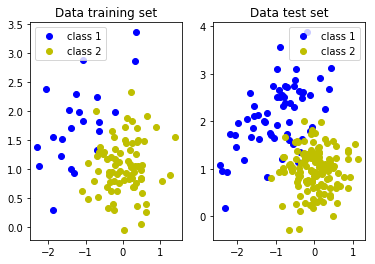

In [7]:
# Training set
synth_train = np.loadtxt('synth_train.txt') 
class_train = synth_train[:,0]
class_train_1 = np.where(synth_train[:,0]==1)[0]
class_train_2 = np.where(synth_train[:,0]==2)[0]
x_train = synth_train[:,1:]
N_train = np.size(x_train,axis=0)

# Test set
synth_test = np.loadtxt('synth_test.txt')
class_test = synth_test[:,0]
class_test_1 = np.where(synth_test[:,0]==1)[0]
class_test_2 = np.where(synth_test[:,0]==2)[0]
x_test = synth_test[:,1:]
N_test = np.size(x_test,axis=0)


plt.subplot(121)
afficher_inference(x_train,class_train,true_labels=None, title = "Data training set",)

plt.subplot(122)
afficher_inference(x_test,class_test,true_labels=None, title = "Data test set",)

We can approximately separate the points with a straight line well, and the points are not too far from each other (in the frontier, there are points of both class 1 and 2) so using logistic regression is interesting.
LDA and QDA could also be used.

### Preparing features for logistic regression (binary classification)
First, we prepare the feature matrix and the target vector associated to 
the training and test sets:


In [8]:
X = np.hstack((np.ones((N_train,1)),x_train))
t = 2-class_train   # 0 if class=2, 1 if class=1

X_test = np.hstack((np.ones((N_test,1)),x_test))
t_test = 2-class_test   # 0 if class=2, 1 if class=1


### Exercise 1 : the logistic function of decision

1. Use the function `regression_logistique.m` to estimate the logistic
regression vector `w`. *Indication : use `Nitermax = 50;
eps_conv=1e-3;`.*
2. Compute the decision function $f(x) = argmax_k P(C_k|x)$ on the test set
to get the classification results. Recall that $y_n=\sigma(w^T x)$ (logistic function)
and that *using vectors* you may directly write $y=\sigma(Xw)$, with the
column of ones in X.
3. Display the results by plotting the points from both the training set
and the test set.
4. Write the equation which defines the decision boundary.
5. Artificially add a few points to the training set far from the decision boundary to check the robustness of logistic regression to outliers. Check the behaviour of LDA for comparison in this case and comment. 


Trainig set
error rate : 3.0 %
Test set
error rate : 6.0 %


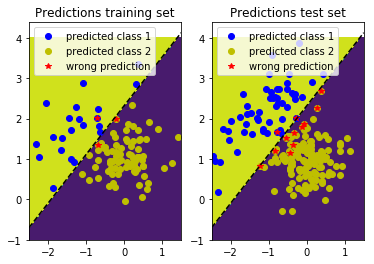

In [9]:
#Exercise 1
LR = Logistic_Regression()
LR.train(x_train, t)

plt.subplot(121)
print("Trainig set")
LR.plot_result(x_train, class_train,title="Predictions training set")
plot_DB_logistic(LR.w)

plt.subplot(122)
print("Test set")
LR.plot_result(x_test, class_test,title="Predictions test set")
plot_DB_logistic(LR.w)

A point X = (x,y) is in the decision boundary if <br>
    $sigmoid(X,w) = 0.5 <=> Xw = 0 , <=> $ y = - $\frac{w_0 + w_1 x }{w_2} $

#### Robustness to outliers

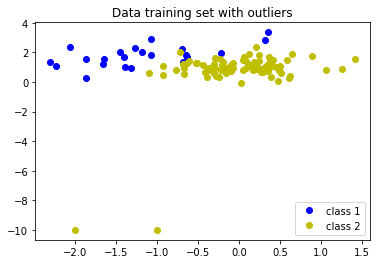

In [10]:
## Construct new data with outliers

# Outliers: 1st column is class, 2nd and 3rd are features
synth_outliers = np.array([[2, -2, -10],
                            [2, -1,-10]]) 

# Training set with outliers
synth_train_outliers = np.concatenate((synth_train,synth_outliers))

class_train_outliers = synth_train_outliers[:,0]
x_train_outliers = synth_train_outliers[:,1:]

t_outliers = 2-class_train_outliers   # 0 if class=2, 1 if class=1


N_train_outliers = np.size(x_train_outliers,axis=0)

X_outliers = add_feature["one"](x_train_outliers)
#X_outliers = np.hstack((np.ones((N_train_outliers,1)),x_train_outliers))
t_outliers = 2-class_train_outliers   # 0 if class=2, 1 if class=1

afficher_inference(x_train_outliers,class_train_outliers,title="Data training set with outliers")

In [11]:
##Logistic regression
#no outliers
w, Niter = regression_logistique(X, t,Nitermax=50, eps_conv=1e-3)
prediction_train = logistic_decision (X,w)
#with outliers
w_outliers, Niter = regression_logistique(X_outliers, t_outliers,Nitermax=50, eps_conv=1e-3)
prediction_train_outliers= logistic_decision (X_outliers,w_outliers)



## LDA 
#no outliers
LDA = LinearDiscriminantAnalysis()
LDA.fit(x_train,class_train)
LDA_prediction_train = LDA.predict(x_train)
#with outliers
LDA_outliers = LinearDiscriminantAnalysis()
LDA_outliers.fit(x_train_outliers,class_train_outliers)
LDA_prediction_train_outliers = LDA_outliers.predict(x_train_outliers)

Error rate training set Logistic regresion no outliers: 3.0 %
Error rate training set Logistic with outliers: 2.9411764705882355 %
Error rate training set LDA no outliers: 3.0 %
Error rate training set LDA with outliers: 8.823529411764707 %


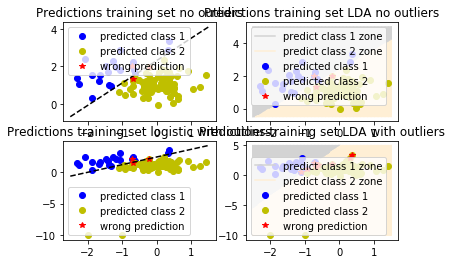

In [12]:
##Logistic regresion 
#no outliers
print("Error rate training set Logistic regresion no outliers:", erreur(prediction_train,class_train),"%")
plt.subplot(221)
afficher_inference (x_train,prediction_train,title = "Predictions training set no outliers",
                    true_labels = class_train)
plot_DB_logistic(w)

#with outliers
print("Error rate training set Logistic with outliers:",erreur(prediction_train_outliers,class_train_outliers),"%")
plt.subplot(223)
afficher_inference (x_train_outliers,prediction_train_outliers,
                    title = "Predictions training set logistic with outliers", true_labels = class_train_outliers)
plot_DB_logistic(w_outliers)


##LDA 
#no outliers
print("Error rate training set LDA no outliers:",erreur(LDA_prediction_train,class_train),"%")
plt.subplot(222)
plot_prediction_zones_LDA(LDA,x2min =-0.5, x2max=5)#plot predictions zones (ie decision boundaries)
afficher_inference (x_train,LDA_prediction_train,
                    title ="Predictions training set LDA no outliers", true_labels = class_train)

#with outliers
print("Error rate training set LDA with outliers:",erreur(LDA_prediction_train_outliers,class_train_outliers),"%")
plt.subplot(224)
plot_prediction_zones_LDA(LDA_outliers)#plot predictions zones
afficher_inference (x_train_outliers,LDA_prediction_train_outliers,
                    title = "Predictions training set LDA with outliers", true_labels = class_train_outliers)

We can see that with logistic regression, the line does not even change, whereas with LDA, the line is very affected by the outliers. This is because outliers don't have a big weight in the logistic regression.

#### Adding quadratic features

error rate : 3.0 %
error rate : 5.5 %


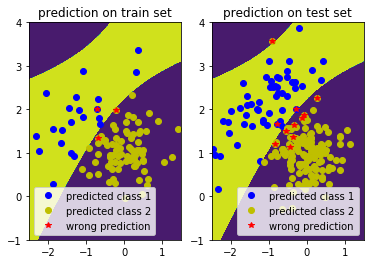

In [13]:
LRq = Logistic_Regression(add_feature="quadratic")
LRq.train(x_train, t)
subplot(121)
LRq.plot_result(x_train, class_train,title="prediction on train set")
subplot(122)
LRq.plot_result(x_test, class_test,title="prediction on test set")

Adding quadratic features is not very useful here because the data can be separated by a straight line. Adding quadratic features would just overfit the data.

## 2. Application: handwritten digits recognition 5 & 6
We load 2 matrices which contain each a sequence of examples of 16x16 images 
of handwritten digits which are 5 and 6 here. Each line of the matrix
contains 256 pixel values coding for the gray level of a 16x16 image.

In [14]:
train_5 = np.loadtxt('train_5.txt',delimiter=',')   # 556 samples
train_6 = np.loadtxt('train_6.txt',delimiter=',')   # 664 samples

### Examples of images


/home/cindy/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


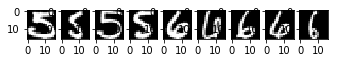

In [15]:
for n in range(5):
    plt.subplot(1,10,n+1)
    n=n 
    I = reshape(train_5[n,:],(16,16))
    plt.imshow(I,cmap='gray')
    
for n in range(5):
    plt.subplot(1,10,n+5)
    n=n
    I = reshape(train_6[n,:],(16,16))
    plt.imshow(I,cmap='gray')

### Separating the training and test sets

We keep in the training set the 145 first images of 5s and the 200 first
images of 6s:


In [16]:
x_train_brut = np.vstack((train_5[:145,:], train_6[:200,:]))
N_train = np.size(x_train_brut,axis=0)
class_train = np.ones((345,1))   # label 1 for digit 6
class_train[:145] = 2      # label 2 for digit 5, it allow to use function from part one

x_test_brut = np.vstack((train_5[145:,:], train_6[200:,:]))
N_test = np.size(train_5,axis=0)+np.size(train_6,axis=0)-N_train
class_test = np.ones((N_test,1))
class_test[:556-145] = 2

t_train = class_train != 2 

## Exercise 2: logistic regression to classify 5 & 6

1. Note that pixel values are between -1 and 1 by using the functions
 `min(I(:))` and `max(I(:))`.
2. Identify the indices of the most significant pixels, which are defined 
as having a standard deviation greater than 0.5 here. We denote by `lis_sig`
the list of positions of these significant pixels in the image vector.
_Indication : the function `std` gives the standard deviation (columnwise
in matrices) and you should find 173 pixel positions.
3. Show a binary image to locate these pixels.
_Indication : `Isig = zeros(16); Isig(list_sig)=1; Isig=Isig';`._
4. Define the training set `x_train` from `x_train_brut` from the significant pixels only.
5. Do the same with `x_test_brut` to extract `x_test`.
6. Use `regression_logistique.m` to estimate the logistic regression vector
`w` from the training set `x_train`. 
Choose `Nitermax = 13; eps_conv = 1e-3;`
7. Compute the decision function and the labels of the test set `x_test`. 
_Indication : do not forget the column of ones !_
8. Estimate the classification error rate by using :
`erreur = sum(abs(class-class_test))/N_test;`.
9. Locate some misclassified examples and visualize the corresponding image.
Comment on your results and observations.


the pixels values are between -1 and 1: -1.0 1.0


Text(0.5,1,'Standard deviation of pixels')

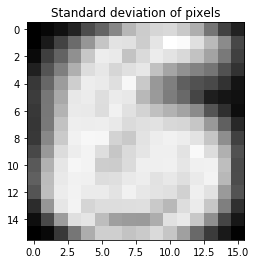

In [17]:
# Exercise 2
print("the pixels values are between -1 and 1:", np.min(I),np.max(I))


std = x_train_brut.std(axis=0).reshape((16,16)) # compute the standard deviation of each pixel
imshow(std,cmap='gray')
title("Standard deviation of pixels")

###### A pixel is significant if the standard deviation > 0.5

We will consider 173 significant pixels


Text(0.5,1,'Significant pixels')

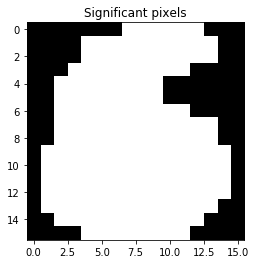

In [18]:
is_significant = x_train_brut.std(axis=0)>0.5 # pixels with standart deviation greater than 0.5
print(f"We will consider { is_significant.sum()} significant pixels")


imshow(is_significant.reshape((16,16)),cmap='gray')
title("Significant pixels")

As expected, in the edges, the pixels are not relevant (they are all black for almost every image)

In [19]:
# We extract the significant features of the training set
x_train = x_train_brut[:,is_significant]
# and of the test set
x_test = x_test_brut[:,is_significant]

In [20]:
LR = Logistic_Regression()
LR.train(x_train, t_train.reshape(-1), Niter=13)
print("Training set")
e = LR.error_rate(x_train, class_train.reshape(-1))
print("Test set")
e = LR.error_rate(x_test, class_test.reshape(-1))

Training set
error rate : 0.0 %
Test set
error rate : 7.885714285714286 %


We have a very low error for the training set and a high error for the test set, we may have overfitted our data.
Futhermore we don't have enough data: 375 in comparaison of the model's complexity : 173 parameters <br> A good way to perform better would be to add regularization.


##### Model with less features : optimizing the hyperparameter of the standard deviation

In the previous section, we said that a pixel is significant when the standard deviation > 0.5. Let's try other values instead of 0.5, and choose a better hyperparameter through cross validation

 Pour max_std = 0.1 , on a  239  features significatifs
 Pour max_std = 0.2 , on a  228  features significatifs
 Pour max_std = 0.30000000000000004 , on a  203  features significatifs
 Pour max_std = 0.4 , on a  191  features significatifs
 Pour max_std = 0.5 , on a  174  features significatifs
 Pour max_std = 0.6000000000000001 , on a  153  features significatifs
 Pour max_std = 0.7000000000000001 , on a  123  features significatifs
 Pour max_std = 0.8 , on a  59  features significatifs


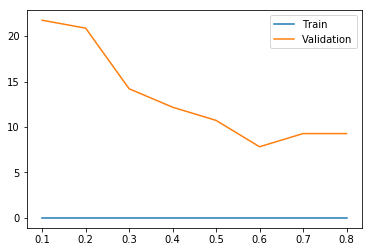

In [21]:
def cross_val(K=5):
    # Nombre de fold de la cross validation
    # Nombre de données total pour les classes 5 et 6
    N_5 = 145
    N_6 = 200
    # nombre de données des classes 5 et 6 par fold
    size_5 = N_5//K
    size_6 = N_6//K
    # Recueil les erreurs moyennes
    moyennes_train = []
    moyennes_test  = []
    # ensemble des écarts-types maximal testés
    xstd = [0.1*j for j in range(1,9)]
    for max_std in xstd:
        # Recueil les erreurs pour un écart type maximal égal à max_std
        error_train = []
        error_test = []
        for i in range(K):

            # Ensemble d'entrainement (on doit récupérer chez les 5 et chez les 6)
            # les 145 premiers élément sont des 5 les suivants sont des 6
            trainset_features_brut = np.vstack((x_train_brut[:i*size_5,:], x_train_brut[(i+1)*size_5:N_5,:],
                                 x_train_brut[N_5 :N_5 + i*size_6,:], x_train_brut[N_5 + (i+1)*size_6 :,:]))
            # Labels
            trainset_labels   = np.ones(N_5 + N_6 - size_5 - size_6)
            trainset_labels[:N_5-size_5] = 2
    ####        # permet de gérer un PB####
            t_labels  = trainset_labels != 2
            # Ensemble de validation
            testset_features_brut = np.vstack((x_train_brut[i*size_5:(i+1)*size_5,:],
                                 x_train_brut[N_5 + i*size_6:N_5 + (i+1)*size_6 ,:]))
            # labels associés
            testset_labels = np.ones(size_5 + size_6)
            testset_labels[:size_5] = 2


            # On sélectionne les features signicicatifs
            is_significant = trainset_features_brut.std(axis=0)>max_std


            trainset_features = trainset_features_brut[:,is_significant]
            testset_features = testset_features_brut[:,is_significant]
            if i == 0:
                print(" Pour max_std =",max_std,", on a ", trainset_features.shape[1]," features significatifs")
            # On effectue la régression logistique
            LRcross_val = Logistic_Regression()

            LRcross_val.train(trainset_features, t_labels,Niter=7)

            # On enregistre les données
            error_train.append(LRcross_val.error_rate(trainset_features, trainset_labels, printer=False))
            error_test.append(LRcross_val.error_rate(testset_features, testset_labels,printer=False))
        # On calcul la moyenne
        moyennes_train.append(np.mean(error_train))
        moyennes_test.append(np.mean(error_test))
    # On affiche le résultat
    plot(xstd, moyennes_train, label = "Train")
    plot(xstd, moyennes_test, label = "Validation")
    legend()
cross_val()

We can see in the plot, that the error in test set is the lowest when max_std = 0.6 <br>
When max_std = 0.6, there are 153 features, the model is a little simpler and litter more precise than the previous model <br>
When max_std = 0.8, we can see that the model has the same score than the first model, but with only 59 features, it is way simpler.

In [22]:
#Through cross validation, we set the optimized std:
optimized_std = 0.6
is_significant_opt = x_train_brut.std(axis=0)>optimized_std # pixels with standart deviation greater than 0.5
print(f"We will consider { is_significant_opt.sum()} significant pixels")

# We extract the significant features of the training set
x_train_opt = x_train_brut[:,is_significant_opt]
# and of the test set
x_test_opt = x_test_brut[:,is_significant_opt]


LR = Logistic_Regression()
LR.train(x_train_opt, t_train.reshape(-1), Niter=13)
print("Training set")
e = LR.error_rate(x_train_opt, class_train.reshape(-1))
print("Test set")
e = LR.error_rate(x_test_opt, class_test.reshape(-1))

We will consider 154 significant pixels
Training set
error rate : 0.0 %
Test set
error rate : 8.228571428571428 %


We actually have a worse error rate than with 0.5, the value before. The error rate is not that different so it's okay. Of course, cross validation doesn't necessarily give the best value since we validate on a validation set, and not on the test set itself. In practice, we would not know that 0.5 would be better than 0.6, so we would have taken 0.6, which is a better choice than 0.2 or 0.9.

### Compare mis- and good- classifed data

803 72


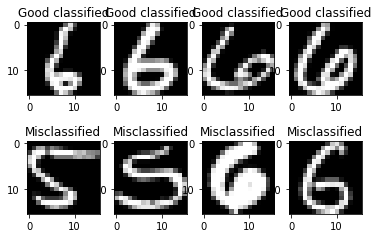

In [23]:
# misclassified images
misclassified = x_test_brut[LR.predict(x_test_opt) != class_test.reshape(-1)]
# goodclassified images
goodclassified = x_test_brut[LR.predict(x_test_opt) == class_test.reshape(-1)]

# Nombre d'images bien et mal classées
n_good =  goodclassified.shape[0]
n_mis =  misclassified.shape[0]
print(n_good,n_mis)
#I = reshape(goodclassified[n,:],(16,16))

for i in range(4):
    # On plot les images bien classées sur la première ligne
    plt.subplot(2,4,1 + i)
    # On affiche une image aléatoirement
    n = np.random.randint(0,n_good)
    plt.imshow(reshape(goodclassified[n,:],(16,16)),cmap='gray')
    plt.title("Good classified")

    # On plot les images mal classées sur la deuxième ligne
    plt.subplot(2,4,4 +1+ i)
    # On affiche une image aléatoirement
    n = np.random.randint(0,n_mis)
    plt.imshow(reshape(misclassified[np.random.randint(0,n_mis),:],(16,16)),cmap='gray')
    plt.title("Misclassified")
plt.show()

The image in the misclassified dataset contain more often images which are difficult to classify, that makes no suprise. But there are also images who seem perfectly normal. It shows that the classifier does not perform very well. As we saw earlier, the classifier has overfitted our training set. Let's try to put some regularization. 

### l2 Regularization


In [24]:
def regression_logistique_l2(X, t, Lambda ,Nitermax=20, eps_conv=1e-3):
    '''Entrees :
    X = [ones(N_train,1) x_train];
    t = class_train 
    Nitermax = nombre maximale d'itérations (20 par défaut)
    eps_conv = critère de convergence sur norm(w-w_old)/norm(w) ; 
    eps_conv=1e-3 par défaut
    
    Sorties : 
    w : vecteur des coefficients de régression logistique
   Niter : nombre d'itérations utilisées effectivement
   
   Fonction de régression logistique pour la classification binaire.
   
   Utilisation :
       Nitermax = 50
       eps_conv = 1e-4
       [w,Niter] = regression_logistique(X,t,Nitermax,eps_conv)
    '''
    N_train = X.shape[0]

    #initialisation : 1 pas de l'algorithme IRLS
    w = np.zeros((X.shape[1],))
    w_old = w 
    y = 1/2*np.ones((N_train,)) # sigma(0) = 1/2
    R = np.diag(y*(1-y))   # diag(y_n(1-y_n))
    w = w_old + la.inv(X.T.dot(R).dot(X) + Lambda*np.eye(X.shape[1])).dot(X.T.dot(y-t) + Lambda*w_old.T)
    # boucle appliquant l'algortihme de Newton-Raphson
    Niter = 1
    while ( (la.norm(w-w_old)/la.norm(w)>eps_conv) & (Niter<Nitermax) ):
        Niter = Niter+1
        y = 1/(1+np.exp(-X.dot(w)))
        R = np.diag(y*(1-y))  # Matrice Hessienne de la fonction coût
        w_old = w 
        # Newton Raphton
        w = w_old - la.inv(X.T.dot(R).dot(X) + Lambda*np.eye(X.shape[1])).dot(X.T.dot(y-t) + Lambda*w_old.T)
         
    return w, Niter


In [25]:
LR = Logistic_Regression()
print("no regularization:")
LR.train(x_train, t_train.reshape(-1), Niter=13)
print("Training set:")
LR.error_rate(x_train, class_train.reshape(-1))
print("Test set")
LR.error_rate(x_test, class_test.reshape(-1))


print("\n l2 regularization:")
LR.train_l2(x_train, t_train.reshape(-1),2, Niter=13)
print("Training set:")
e= LR.error_rate(x_train, class_train.reshape(-1))
print("Test set")
e= LR.error_rate(x_test, class_test.reshape(-1))

no regularization:
Training set:
error rate : 0.0 %
Test set
error rate : 7.885714285714286 %

 l2 regularization:
Training set:
error rate : 0.0 %
Test set
error rate : 2.6285714285714286 %


With l2 regularization, we still have an algorithm which can fit perfectly the training data (this is due to the fact that a solution which gives a set of parameters which fit perfectly the data is not unique). However this time, the error rate on test set is way better. We can also use cross validation to help us find the best lambda.

 Pour max_std = 0.1 , on a  174  features significatifs
 Pour max_std = 0.2 , on a  174  features significatifs
 Pour max_std = 0.30000000000000004 , on a  174  features significatifs
 Pour max_std = 0.4 , on a  174  features significatifs
 Pour max_std = 0.5 , on a  174  features significatifs
 Pour max_std = 0.6000000000000001 , on a  174  features significatifs
 Pour max_std = 0.7000000000000001 , on a  174  features significatifs
 Pour max_std = 0.8 , on a  174  features significatifs
 Pour max_std = 0.9 , on a  174  features significatifs
 Pour max_std = 1.0 , on a  174  features significatifs
 Pour max_std = 1.1 , on a  174  features significatifs
 Pour max_std = 1.2000000000000002 , on a  174  features significatifs
 Pour max_std = 1.3 , on a  174  features significatifs
 Pour max_std = 1.4000000000000001 , on a  174  features significatifs
 Pour max_std = 1.5 , on a  174  features significatifs
 Pour max_std = 1.6 , on a  174  features significatifs
 Pour max_std = 1.7000000000

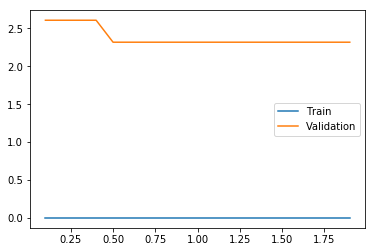

In [26]:
def cross_val2(K=5):
    # Nombre de fold de la cross validation
    # Nombre de données total pour les classes 5 et 6
    N_5 = 145
    N_6 = 200
    # nombre de données des classes 5 et 6 par fold
    size_5 = N_5//K
    size_6 = N_6//K
    # Recueil les erreurs moyennes
    moyennes_train = []
    moyennes_test  = []
    # ensemble des écarts-types maximal testés
    lambdas = [0.1*j for j in range(1,20)]
    for Lambda in lambdas:
        # Recueil les erreurs pour un écart type maximal égal à max_std
        error_train = []
        error_test = []
        for i in range(K):

            # Ensemble d'entrainement (on doit récupérer chez les 5 et chez les 6)
            # les 145 premiers élément sont des 5 les suivants sont des 6
            trainset_features_brut = np.vstack((x_train_brut[:i*size_5,:], x_train_brut[(i+1)*size_5:N_5,:],
                                 x_train_brut[N_5 :N_5 + i*size_6,:], x_train_brut[N_5 + (i+1)*size_6 :,:]))
            # Labels
            trainset_labels   = np.ones(N_5 + N_6 - size_5 - size_6)
            trainset_labels[:N_5-size_5] = 2
    ####        # permet de gérer un PB####
            t_labels  = trainset_labels != 2
            # Ensemble de test
            testset_features_brut = np.vstack((x_train_brut[i*size_5:(i+1)*size_5,:],
                                 x_train_brut[N_5 + i*size_6:N_5 + (i+1)*size_6 ,:]))
            # labels associés
            testset_labels = np.ones(size_5 + size_6)
            testset_labels[:size_5] = 2


            # On sélectionne les features signicicatifs
            is_significant = trainset_features_brut.std(axis=0)>0.5


            trainset_features = trainset_features_brut[:,is_significant]
            testset_features = testset_features_brut[:,is_significant]
            if i == 0:
                print(" Pour max_std =",Lambda,", on a ", trainset_features.shape[1]," features significatifs")
            # On effectue la régression logistique
            LRcross_val = Logistic_Regression()

            LRcross_val.train_l2(trainset_features, t_labels,Lambda=Lambda,Niter=7)

            # On enregistre les données
            error_train.append(LRcross_val.error_rate(trainset_features, trainset_labels, printer=False))
            error_test.append(LRcross_val.error_rate(testset_features, testset_labels,printer=False))
        # On calcul la moyenne
        moyennes_train.append(np.mean(error_train))
        moyennes_test.append(np.mean(error_test))
    # On affiche le résultat
    plot(lambdas, moyennes_train, label = "Train")
    plot(lambdas, moyennes_test, label = "Validation")
    legend()
cross_val2()

## 3. Logistic regression using `scikit-learn`

1. **Go to** http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for a presentation of the logistic regression model in `scikit-learn`.

2. **Apply** it to the present data set.

3. **Comment** on the use of logistic regression.

*Indication : you may have a look at* 

a) Theory : http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex5/ex5.html

b) Video :  https://www.coursera.org/learn/machine-learning/lecture/4BHEy/regularized-logistic-regression 

c) Example : http://scikit-learn.org/stable/auto_examples/exercises/plot_digits_classification_exercise.html#sphx-glr-auto-examples-exercises-plot-digits-classification-exercise-py

*for a short presentation of regularized logistic regression.*

In [27]:
from keras.preprocessing import image 
pylab.rcParams['figure.figsize'] = (10, 5)
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
train_5 = np.loadtxt('train_5.txt',delimiter=',')   # 556 samples
train_6 = np.loadtxt('train_6.txt',delimiter=',')   # 664 samples

x_train_brut = np.vstack((train_5[:145,:], train_6[:200,:]))
N_train = np.size(x_train_brut,axis=0)
class_train = np.ones((345,1))   # label 1 for digit 6
class_train[:145] = 2      # label 2 for digit 5, it allow to use function from part one

x_test_brut = np.vstack((train_5[145:,:], train_6[200:,:]))
N_test = x_test_brut.shape[0]
class_test = np.ones((N_test,1))
class_test[:556-145] = 2

t_train = class_train != 2 

/home/cindy/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Parameters of LogisticRegression scikit learn : 
- solver : Here, all solvers gives more or less similar results (Logistic regression is a convex optimization problem). We choose to work with liblinear solver. As specified in the doc of scikit learn, liblinear is a good choice for "small" datasets. Plus, it supports l1 and l2 penalty. 
- penalty : we will try l1 and l2. Penalty allows us to avoid overfitting the data. l1 penalty which encourages sparsity, makes sense: its effect would be to get rid of the unsignificant pixels.
- class_weight : If we set it to 'balanced', the algorithm performs better, but this is because our data have more digits 6 than 5, in both training and test set. But here, we should not use it because nothing tells us that in the test set, we would also have more 6.

#### l2 Penalty

In [28]:
## With penalty l2
print("LR with l2 penalty:")
LR_penalty_l2 = LogisticRegression(solver='liblinear', class_weight='balanced', penalty='l2',
                                           multi_class='ovr')
LR_penalty_l2.fit(x_train_brut,class_train)
pred_train_no_penalty = LR_penalty_l2.predict(x_train_brut).reshape(class_train.shape)
pred_test_no_penalty = LR_penalty_l2.predict(x_test_brut).reshape(class_test.shape)

error_train_no_penalty = LR_penalty_l2.score(x_train_brut,class_train)
error_test_no_penalty = LR_penalty_l2.fit(x_train_brut,class_train).score(x_test_brut,class_test)
print("- with class_weight: (better performance)")
e = erreur(pred_test_no_penalty,class_test,printer=True)

LR_penalty_l2 = LogisticRegression(solver='liblinear', 
                                           multi_class='ovr')
LR_penalty_l2.fit(x_train_brut,class_train)
pred_train_penalty_l2 = LR_penalty_l2.predict(x_train_brut).reshape(class_train.shape)
pred_test_penalty_l2 = LR_penalty_l2.predict(x_test_brut).reshape(class_test.shape)

error_train_penalty_l2 = LR_penalty_l2.score(x_train_brut,class_train)
error_test_penalty_l2 = LR_penalty_l2.fit(x_train_brut,class_train).score(x_test_brut,class_test)
print("- without class_weight: (In the sequel, we'll work without class_weight since it's irrelevant here)")
e = erreur(pred_test_penalty_l2,class_test,printer=True)

LR with l2 penalty:
- with class_weight: (better performance)
error rate : 2.2857142857142856 %
- without class_weight: (In the sequel, we'll work without class_weight since it's irrelevant here)
error rate : 2.4 %


/home/cindy/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/cindy/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/cindy/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/cindy/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

In [ ]:
# misclassified image
misclassified_l2 = x_test_brut[pred_test_penalty_l2.reshape(-1) != class_test.reshape(-1)]
print("There are ", misclassified_l2.shape[0], " misclassified classes, for l2 penalty LR:")
for n in range(misclassified_l2.shape[0]):
    plt.subplot(3,10,n+1)
    I = reshape(misclassified_l2[n,:],(16,16))
    plt.imshow(I,cmap='gray')


There are  21  misclassified classes, for l2 penalty LR:


Some of those misclassfied class couldn't be recognized even by a human so we can understand that the algorithm doesn't reognize them either. However, some digits are very recognizable : for example on the second line, the 6 are quite recognizable. This misclassification might come from the lack of data. Therefore, one idea could be to augment the data by adding some more digits which have been transformed (rotation angle, zoom etc..)

In [ ]:
## With penalty l1
print("LR with l1 penalty :")
LR_penalty_l1 = LogisticRegression(solver='liblinear', penalty='l1',
                                           multi_class='ovr')
LR_penalty_l1.fit(x_train_brut,class_train)
pred_train_penalty_l1 = LR_penalty_l1.predict(x_train_brut).reshape(class_train.shape)
pred_test_penalty_l1 = LR_penalty_l1.predict(x_test_brut).reshape(class_test.shape)

error_train_penalty_l1 = LR_penalty_l1.score(x_train_brut,class_train)
error_test_penalty_l1 = LR_penalty_l1.fit(x_train_brut,class_train).score(x_test_brut,class_test)
e= erreur(pred_test_penalty_l1,class_test,printer=True)

In [ ]:
# misclassified image
misclassified_l1 = x_test_brut[pred_test_penalty_l1.reshape(-1) != class_test.reshape(-1)]
print("There are ", misclassified_l1.shape[0], " misclassified classes, for l1 penalty LR:")
for n in range(10):
    plt.subplot(3,10,n+1)
    n=n
    I = reshape(misclassified_l1[n,:],(16,16))
    plt.imshow(I,cmap='gray')
    
for n in range(10):
    plt.subplot(3,10,n+11)
    n=n+10
    I = reshape(misclassified_l1[n,:],(16,16))
    plt.imshow(I,cmap='gray')
    
for n in range(8):
    plt.subplot(3,10,n+21)
    n=n+20
    I = reshape(misclassified_l1[n,:],(16,16))
    plt.imshow(I,cmap='gray')
    

The results with l1 penalty are slightly worse than with l2 penalty. Both of them avoid overfitting the data, so it's better than with no penalty at all. Maybe the reason why l1 performs less well is because it gets rid of pixels which actually are significant for some images. For example, if we have a lot of "small" digits (ie which cover just a little part of the space in the center, cf figure (a) below), l1 penalty will tend to say that the black pixels around the 6 are irrelevant. Such that, if we have to predict a big 6 (ie which covers the entire space, cf figure (b) below), the algorithm won't recognize it, since it the pixels on the edges are considered irrelevant.

In [ ]:
### figure (a) and figure (b)

plt.subplot (1,2,1)
img_small = misclassified_l1[-5,:].reshape((16,16))
plt.imshow(img_small,cmap='gray')
plt.title("figure (a), small 6")

plt.subplot (1,2,2)
img_small = misclassified_l1[-8,:].reshape((16,16))
plt.imshow(img_small,cmap='gray')
plt.title("figure (b), big 6")

##### Data augmentation

We can try to augment our dataset, by rotating some images, or zooming them, moving them, and so on.
For example:

In [ ]:
datagen = image.ImageDataGenerator()

transform_parameters = {'theta':0, 
                        'shear':50,
                       'zy': 1.9
                        }

In [ ]:
#x_train_augmented = x_train_brut.reshape((x_train_brut.shape[0],1,16,16))
N_train_5 = 145 # number of training data of class 5
N_train_6 = 200
N_new_data = 140 #number of new 5 or new 6 generated

new_5_train = np.zeros((N_new_data,16*16))
new_6_train = np.zeros((N_new_data,16*16))
i=1
for k in range(N_new_data):
    new_5_train[k] = datagen.apply_transform(train_5[k].reshape(1,16,16),transform_parameters).reshape((16*16))
    new_6_train[k] = datagen.apply_transform(train_6[k].reshape(1,16,16),transform_parameters).reshape((16*16))
    if k%100==0:
        plt.subplot(1,5,i)
        plt.imshow(new_6_train[k].reshape(16,16),cmap='gray')
        plt.title("transformed image")
        i+=1
        plt.subplot(1,5,i)
        plt.imshow(train_6[k].reshape(16,16),cmap='gray')
        plt.title("original image")
        i+=1


x_train_augmented = np.vstack((train_5[:N_train_5,:],new_5_train, train_6[:N_train_6,:],new_6_train))
N_train = x_train_brut.shape[0]
class_train = np.ones((x_train_augmented.shape[0],1))   # label 1 for digit 6
class_train[:N_train_5+N_new_data] = 2      # label 2 for digit 5

x_test_brut = np.vstack((train_5[N_train_5:,:], train_6[N_train_6:,:]))
N_test = x_test_brut.shape[0]
class_test = np.ones((N_test,1))
class_test[:556-N_train_5] = 2

t_train = class_train != 2 
#x_train_brut = preprocessing.scale(x_train_brut)
datagen = image.ImageDataGenerator()

In [ ]:
## With penalty l2
print("LR with l2 penalty:")

LR_penalty_l2 = LogisticRegression(solver='liblinear', 
                                           multi_class='ovr')
LR_penalty_l2.fit(x_train_augmented,class_train)
pred_train_penalty_l2_augmented = LR_penalty_l2.predict(x_train_augmented).reshape(class_train.shape)
pred_test_penalty_l2_augmented = LR_penalty_l2.predict(x_test_brut).reshape(class_test.shape)

erreur(pred_test_penalty_l2_augmented,class_test,printer=True)

In [ ]:
# misclassified image
misclassified_l2_augmented = x_test_brut[pred_test_penalty_l2_augmented.reshape(-1) != class_test.reshape(-1)]
print("There are ", misclassified_l2_augmented.shape[0], " misclassified classes, with data augmentation:")
for n in range(misclassified_l2_augmented.shape[0]):
    plt.subplot(3,10,n+1)
    I = reshape(misclassified_l2_augmented[n,:],(16,16))
    plt.imshow(I,cmap='gray')
    plt.title(n)
plt.show()
print("There were ", misclassified_l2.shape[0], " misclassified classes, without data augmentation:")
for n in range(misclassified_l2.shape[0]):
    plt.subplot(3,10,n+1)
    I = reshape(misclassified_l2[n,:],(16,16))
    plt.imshow(I,cmap='gray')
    plt.title(n)

There are less mistakes with data augmentation. <br>
Some misclassified digits are now well classified, but among those, there are some unreadable digits like the digit n°8 (in the 3rd line), are now well classified, which is not satisfying. <br> 
However, we think we could have tuned the parameters of the data augmentation better than this. (in particular, we didn't manage to tune the zoom out with respect to axis x...)

###### What if we had less data? Let's try with only 10 training examples

In [ ]:
datagen = image.ImageDataGenerator()

transform_parameters = {'theta':0, 
                       'shear':50,
                        #'tx':12 ,
                        #'ty':1,
                        #'zx':13,
                       'zy': 1.9
                        }

In [ ]:
N_train_5 = 10 # number of training data of class 5
N_train_6 = 10
N_new_data = 10 #number of new 5 or new 6 generated

new_5_train = np.zeros((N_new_data,16*16))
new_6_train = np.zeros((N_new_data,16*16))
i=1
for k in range(N_new_data):
    new_5_train[k] = datagen.apply_transform(train_5[k].reshape(1,16,16),transform_parameters).reshape((16*16))
    new_6_train[k] = datagen.apply_transform(train_6[k].reshape(1,16,16),transform_parameters).reshape((16*16))

        
x_train_brut = np.vstack((train_5[:N_train_5,:], train_6[:N_train_6,:]))
N_train_brut = x_train_brut.shape[0]
class_train_brut = np.ones((x_train_brut.shape[0],1))   # label 1 for digit 6
class_train_brut[:N_train_5] = 2      # label 2 for digit 5


x_train_augmented = np.vstack((train_5[:N_train_5,:],new_5_train, train_6[:N_train_6,:],new_6_train))
N_train_augmented = x_train_brut.shape[0]
class_train_augmented = np.ones((x_train_augmented.shape[0],1))   # label 1 for digit 6
class_train_augmented[:N_train_5+N_new_data] = 2      # label 2 for digit 5

x_test_brut = np.vstack((train_5[N_train_5:,:], train_6[N_train_6:,:]))
N_test = x_test_brut.shape[0]
class_test = np.ones((N_test,1))
class_test[:556-N_train_5] = 2

t_train = class_train != 2 
#x_train_brut = preprocessing.scale(x_train_brut)
datagen = image.ImageDataGenerator()

In [ ]:
## With penalty l2
print("LR with l2 penalty, without data augmentation:")

LR_penalty_l2 = LogisticRegression(solver='liblinear', 
                                           multi_class='ovr')
LR_penalty_l2.fit(x_train_brut,class_train_brut)
pred_train_penalty_l2 = LR_penalty_l2.predict(x_train_brut).reshape(class_train_brut.shape)
pred_test_penalty_l2 = LR_penalty_l2.predict(x_test_brut).reshape(class_test.shape)

e = erreur(pred_test_penalty_l2,class_test,printer=True)

In [ ]:
## With penalty l2
print("LR with l2 penalty, and data augmentation:")

LR_penalty_l2 = LogisticRegression(solver='liblinear', 
                                           multi_class='ovr')
LR_penalty_l2.fit(x_train_augmented,class_train_augmented)
pred_train_penalty_l2_augmented = LR_penalty_l2.predict(x_train_augmented).reshape(class_train_augmented.shape)
pred_test_penalty_l2_augmented = LR_penalty_l2.predict(x_test_brut).reshape(class_test.shape)

e = erreur(pred_test_penalty_l2_augmented,class_test,printer=True)

With data augmentation it's slightly better. And again, if we tune the parameters for the data augmentation better, we think we could have better results.